<h1 align="center">QC and filtering</h1> 
<hr style="border:2px solid black"> </hr>

**Quality control**

"We must ensure that all cellular barcode data correspond to viable cells.

Cell QC is commonly performed based on three QC covariates: the number of counts per barcode (count depth), the number of genes per barcode, and the fraction of counts from mitochondrial genes per barcode.

The distributions of these QC covariates are examined for outlier peaks that are filtered out by thresholding.

These outlier barcodes can correspond to dying cells, cells whose membranes are broken, or doublets".

Samples with a low count depth, few detected genes, and a high fraction of mitochondrial counts are indicative of cells whose cytoplasmic mRNA has leaked out through a broken membrane.

In contrast, cells with unexpectedly high counts and a large number of detected genes may represent doublets.

**DOI: 10.15252/msb.20188746**

# A: loading packages and setup

In [1]:
#####################IMPORTING PACKAGES#############################
import sctoolbox
import scanpy as sc
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sctoolbox.checker import *
from sctoolbox.creators import *
from sctoolbox.qc_filter import *
from sctoolbox.analyser import *
from sctoolbox.plotting import *
from sctoolbox.marker_genes import *
from sctoolbox.utilities import *
from os import path
from scipy import sparse

# B: loading the anndata setting the condition

In [2]:
#Set parameter bellow
#help(load_anndata)
adata = load_anndata(is_from_previous_note=True, notebook=2, data_to_evaluate="condition")
display(adata)

AnnData object with n_obs × n_vars = 20192 × 55359
    obs: 'condition'
    var: 'gene_ids', 'feature_types'
    uns: 'color_set', 'infoprocess'
    layers: 'ambiguous', 'spliced', 'unspliced'

# C: Labelling genes

In [3]:
#Labeling genes (Optional). Set label=False to skip
adata=label_genes(adata, label=True)
display(adata.uns["infoprocess"]["genes_labeled"])

Annotate mitochondrial? Choose y or ny
Type the string (case sensitivy) used to identify mit genes, e.g., mt, Mt-, so on.mt
Annotate cell_cycle? Choose y or ny
Choose one species: human, mouse, rat, zebrafishmouse
Annotate gender_genes? Choose y or ny
Annotate custom? Choose y or nn


['is_mitochondrial', 'is_cell_cycle', 'is_gender_genes']

# D: calculating QC metrics

In [4]:
#Calculating QC metrics
#If control_var=True, the anndata.var labeled genes you want to control the metrics calculation
adata=qcmetric_calculator(adata, control_var=True)

# E: Establishing the cutoffs for QC and filtering steps

**E1: DEFINING DEFAULT CUTOFFS FOR THE total_counts**

Low and high count depth indicates cells with low integrity and doublets, respectively (DOI: 10.15252/msb.20188746).

Defining and ploting cutoffs only for total_counts


,data_to_evaluate,parameters,cutoff,strategy
0,room_air,total_counts,"[33517.19999999999, 7639.8]",filter_cells
1,smooke_exposure,total_counts,"[18220.199999999997, 3981.9]",filter_cells


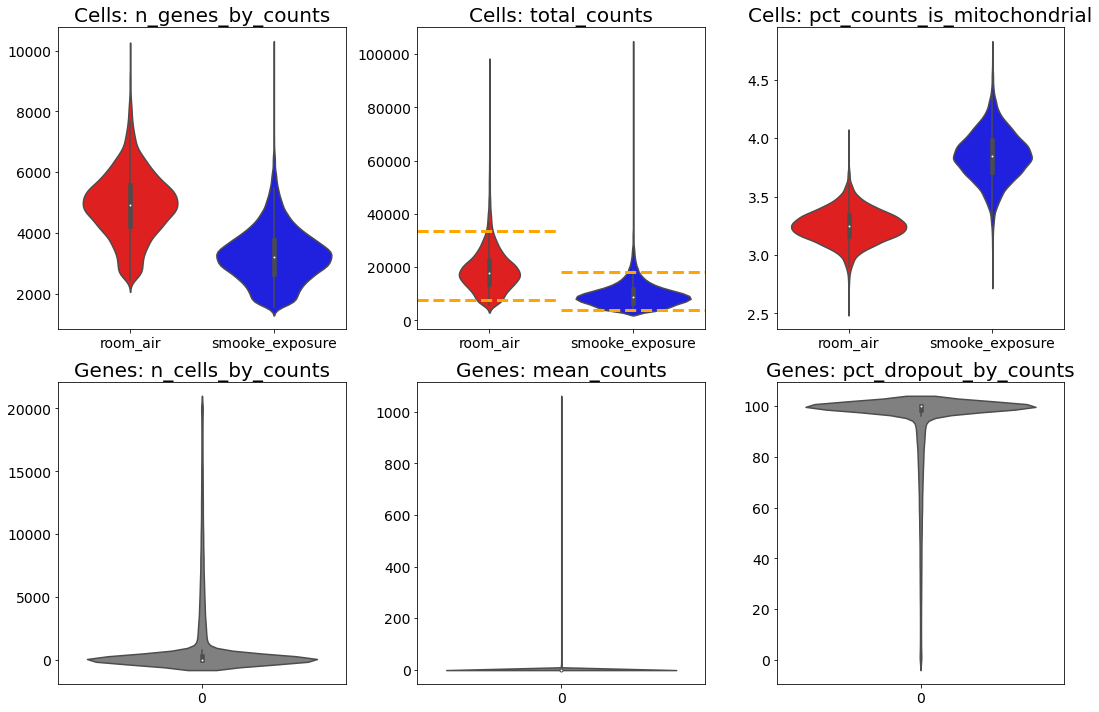

In [5]:
#Defining the default cutoffs for total_counts and ploting data
def_cut=set_def_cuts(adata, interval=0.95, save=False)

**E2: DEFINING CUSTOM CUTOFFS FOR total_counts**

In [6]:
#Refining cutoffs
go_cut=refining_cuts(adata, def_cut)
display(go_cut)

The default setting is:


,data_to_evaluate,parameters,cutoff,strategy
0,room_air,total_counts,"[33517.19999999999, 7639.8]",filter_cells
1,smooke_exposure,total_counts,"[18220.199999999997, 3981.9]",filter_cells




#########################################################
NOTE. Choose: 
	1) custom to define new cutoffs
	2) def to use the previously defined cutoffs
#########################################################

room_air total_counts: custom or defdef
smooke_exposure total_counts: custom or defdef


,data_to_evaluate,parameters,cutoff,strategy
0,room_air,total_counts,"[33517.19999999999, 7639.8]",filter_cells
1,smooke_exposure,total_counts,"[18220.199999999997, 3981.9]",filter_cells


**E3: FILTERING THE total_counts**

Low and high count depth indicates cells with low integrity and doublets, respectively (DOI: 10.15252/msb.20188746).

In [7]:
#Filtering the total counts
adata2=anndata_filter(adata, go_cut)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 20192 × 55359
    obs: 'condition', 'n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial', 'total_counts_is_cell_cycle', 'pct_counts_is_cell_cycle', 'total_counts_is_gender_genes', 'pct_counts_is_gender_genes'
    var: 'gene_ids', 'feature_types', 'is_mitochondrial', 'is_cell_cycle', 'is_gender_genes', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts'
    uns: 'color_set', 'infoprocess', 'condition_colors'
    layers: 'ambiguous', 'spliced', 'unspliced'
AnnData object with n_obs × n_vars = 18172 × 55359
    obs: 'condition', 'n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial', 'total_counts_is_cell_cycle', 'pct_counts_is_cell_cycle', 'total_counts_is_gender_genes', 'pct_counts_is_gender_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'is_mitochondrial', 'is_cell_cycle', 'is_

**E4: DEFINING DEFAULT CUTOFFS FOR THE OTHER PARAMETERS**

This step needs to be performed only after satisfatory total_counts filtering.

NOTE: use the adata2, because this is the object with the total_counts filtered

,data_to_evaluate,parameters,cutoff,strategy
0,room_air,n_genes_by_counts,"[6305.0, 3390.0]",filter_cells
1,room_air,pct_counts_is_mitochondrial,"[3.4768957138061523, 3.02901611328125]",filter_cells
2,smooke_exposure,n_genes_by_counts,"[4463.299999999999, 2087.7]",filter_cells
3,smooke_exposure,pct_counts_is_mitochondrial,"[4.190464210510254, 3.501874232292175]",filter_cells
4,_,n_cells_by_counts,[18712.903040149537],filter_genes
5,_,mean_counts,[0.7444136202335349],filter_genes
6,_,pct_dropout_by_counts,[93.03650042057994],filter_genes


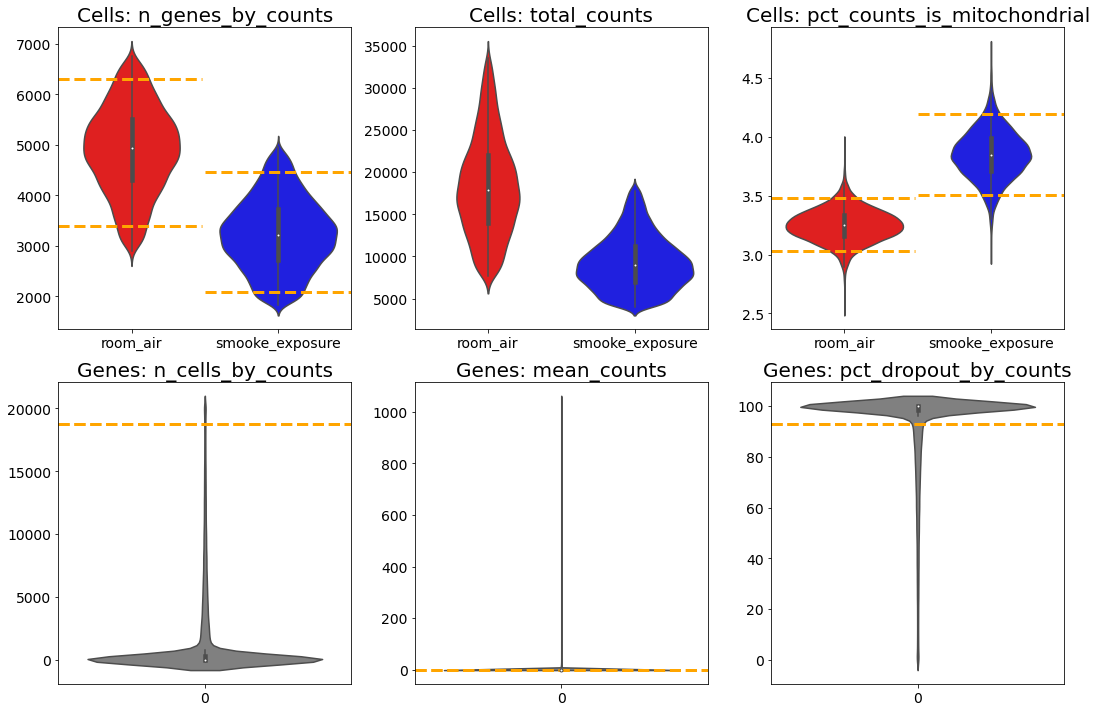

In [8]:
#Defining the default cutoffs for all other parameters
def_cut=set_def_cuts(adata2, interval=0.95, save=False)

**E5: DEFINING CUSTOM CUTOFFS FOR ALL OTHER VARIABLES**

Here you need to use the adata3, because this is the one that had the total_counts already filtered

In [9]:
#Refining cutoffs
go_cut=refining_cuts(adata2, def_cut)
display(go_cut)

The default setting is:


,data_to_evaluate,parameters,cutoff,strategy
0,room_air,n_genes_by_counts,"[6305.0, 3390.0]",filter_cells
1,room_air,pct_counts_is_mitochondrial,"[3.4768957138061523, 3.02901611328125]",filter_cells
2,smooke_exposure,n_genes_by_counts,"[4463.299999999999, 2087.7]",filter_cells
3,smooke_exposure,pct_counts_is_mitochondrial,"[4.190464210510254, 3.501874232292175]",filter_cells
4,_,n_cells_by_counts,[18712.903040149537],filter_genes
5,_,mean_counts,[0.7444136202335349],filter_genes
6,_,pct_dropout_by_counts,[93.03650042057994],filter_genes




#########################################################
NOTE. Choose: 
	1) custom to define new cutoffs
	2) def to use the previously defined cutoffs
	3) skip to avoid filter this parameter
#########################################################

room_air n_genes_by_counts: custom, def or skipskip
room_air pct_counts_is_mitochondrial: custom, def or skipcustom
room_air pct_counts_is_mitochondrial: minimun cutoff [FLOAT or INT]3.5
room_air pct_counts_is_mitochondrial: maximum cutoff [FLOAT or INT]3.5
smooke_exposure n_genes_by_counts: custom, def or skipskip
smooke_exposure pct_counts_is_mitochondrial: custom, def or skipcustom
smooke_exposure pct_counts_is_mitochondrial: minimun cutoff [FLOAT or INT]4.2
smooke_exposure pct_counts_is_mitochondrial: maximum cutoff [FLOAT or INT]4.2
_ n_cells_by_counts: custom, def or skipcustom
_ n_cells_by_counts: minimun cutoff [FLOAT or INT]2500
_ n_cells_by_counts: maximum cutoff [FLOAT or INT]2500
_ mean_counts: custom, def or skipcustom
_ mea

,data_to_evaluate,parameters,cutoff,strategy
0,room_air,n_genes_by_counts,skip,filter_cells
1,room_air,pct_counts_is_mitochondrial,"[3.5, 3.5]",filter_cells
2,smooke_exposure,n_genes_by_counts,skip,filter_cells
3,smooke_exposure,pct_counts_is_mitochondrial,"[4.2, 4.2]",filter_cells
4,_,n_cells_by_counts,"[2500.0, 2500.0]",filter_genes
5,_,mean_counts,"[100.0, 100.0]",filter_genes
6,_,pct_dropout_by_counts,skip,filter_genes


**E6: FILTERING THE OTHER PARAMETERS**

In [10]:
#Filtering other parameters
adata3=anndata_filter(adata2, go_cut)

AnnData object with n_obs × n_vars = 17390 × 7845
    obs: 'condition', 'n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial', 'total_counts_is_cell_cycle', 'pct_counts_is_cell_cycle', 'total_counts_is_gender_genes', 'pct_counts_is_gender_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'is_mitochondrial', 'is_cell_cycle', 'is_gender_genes', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'
!!!!!!!!!!!!!!!!!!!
AnnData object with n_obs × n_vars = 17390 × 7845
    obs: 'condition', 'n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial', 'total_counts_is_cell_cycle', 'pct_counts_is_cell_cycle', 'total_counts_is_gender_genes', 'pct_counts_is_gender_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'is_mitochondrial', 'is_cell_cycle', 'is_gender_genes', 

**E7: Remove ribosomal/mitochrondrial/gender genes/and others**

Optional

In [11]:
#remove mitochondrial
#adata4 = sctoolbox.qc_filter.filter_genes(adata3, "is_mitochondrial")
    
#remove cell cycle
#adata4 = sctoolbox.qc_filter.filter_genes(adata3, "is_cell_cycle")

#Remove gender genes
#adata4 = sctoolbox.qc_filter.filter_genes(adata3, "is_gender_genes")

#Remove custom genes from list
#adata4 = sctoolbox.qc_filter.filter_genes(adata3, "is_custom")

**E8: Final plotting**

You choose not plot cutoffs


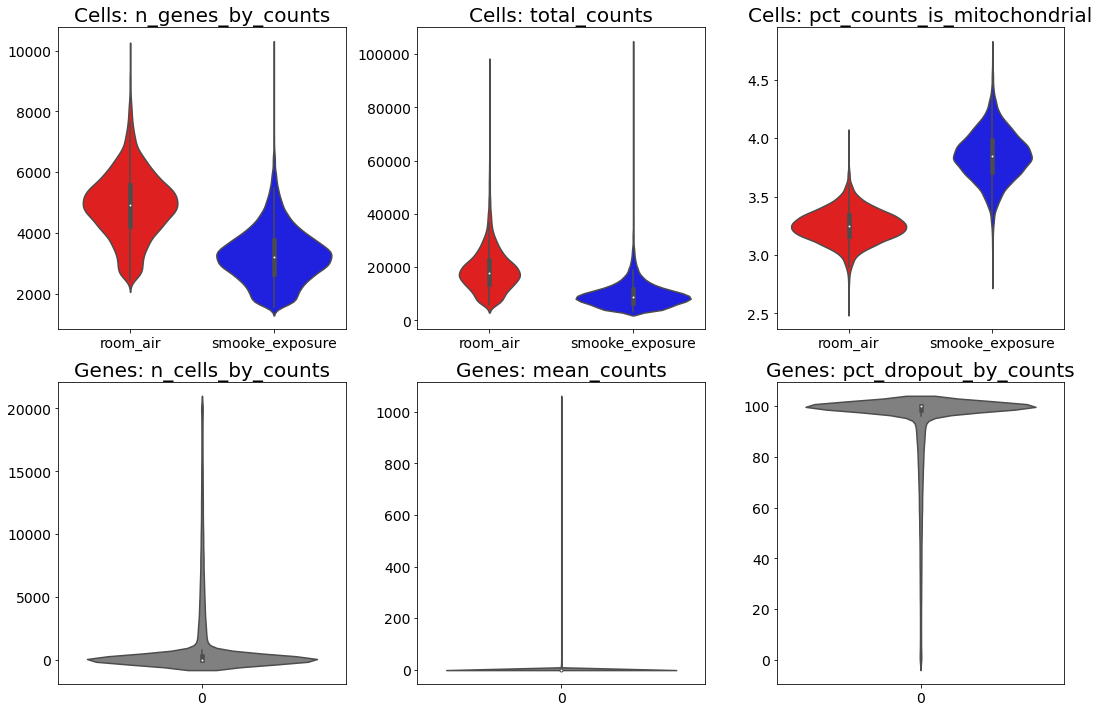

In [12]:
#Raw anndata
set_def_cuts(adata, only_plot=True, save=False)

You choose not plot cutoffs


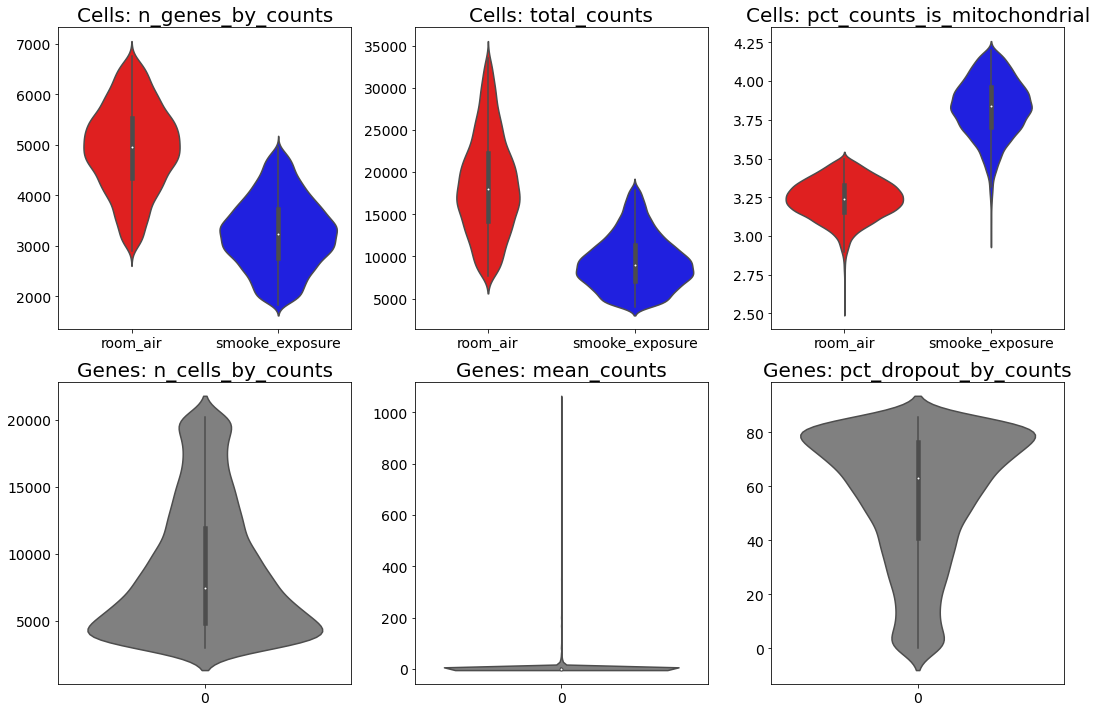

In [13]:
#Filtered annadta
set_def_cuts(adata3, only_plot=True, save=False)

# F: Save the final adata

In [14]:
#Saving the anndata
#Modify bellow as needed
adata_output= adata3.uns["infoprocess"]["Anndata_path"] + "/anndata_2_" + adata3.uns["infoprocess"]["Test_number"] + ".h5ad"
adata.write(filename=adata_output)